```
아직 고쳐야 할 부분이 많은데, 우선 업로드 합니다 !
````


### 형태소를 뽑아서 sig_morph column + 
- 현재 시제 : '-ㄴ-', '-는', '-은'
- 과거 시제 : '-았-', '-었-', '-였-'
- 미래 시제 : '-겠-', 'ㄹ 것이다'


In [1]:
import pandas as pd
import numpy as np
import os
import random
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore') 

os.listdir('./ML_project')

['cleandata', '.DS_Store', 'test.csv', 'train.csv', 'sample_submission.csv']

In [2]:
train = pd.read_csv('./ML_project/train.csv').drop(['유형', '극성', '확실성', 'label'], axis=1)
test = pd.read_csv('./ML_project/test.csv')

train.head()

,ID,문장,시제
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,현재
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,과거
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,미래
3,TRAIN_00003,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",과거
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,현재


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16541 entries, 0 to 16540
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      16541 non-null  object
 1   문장      16541 non-null  object
 2   시제      16541 non-null  object
dtypes: object(3)
memory usage: 387.8+ KB


---

### 중복 문장 존재. 삭제
- train data
-  14989  각 레이스가 종료되면 ＇우마무스메＇들이 무대에 올라 눈과 귀를 즐겁게하는 공연을 펼친다.	현재 -> 삭제
-  7269  각 레이스가 종료되면 ＇우마무스메＇들이 무대에 올라 눈과 귀를 즐겁게하는 공연을 펼친다.	미래

-  7099	 이들 게임은 국내 구글 플레이 매출 톱10 진입이 예상되는 기대작이다.	현재 -> 삭제
-  4670	 이들 게임은 국내 구글 플레이 매출 톱10 진입이 예상되는 기대작이다.	미래

총 35 * 2 데이터 중 앞 데이터들 삭제

- test data에도 중복값 있으나, label 없고 건드릴 수 없으니 pass


https://kongdols-room.tistory.com/124


In [4]:
pd.set_option('display.max_rows', 100)
train[train[['문장']].duplicated(keep=False)].sort_values('문장').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 1152 to 1823
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      70 non-null     object
 1   문장      70 non-null     object
 2   시제      70 non-null     object
dtypes: object(3)
memory usage: 2.2+ KB


In [5]:
train = train.loc[train.ID != 'TRAIN_14989']
train = train.loc[train.ID != 'TRAIN_07099']
train = train.drop_duplicates('문장', keep = 'first')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16506 entries, 0 to 16539
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      16506 non-null  object
 1   문장      16506 non-null  object
 2   시제      16506 non-null  object
dtypes: object(3)
memory usage: 515.8+ KB


---

#### 랜덤 문장 예시 보기 (승범님 코드)

In [7]:
types = train['시제'].unique().tolist()
type_sort_dict = dict()
for t in types:
    type_sort_dict[t] = train[train['시제']==t].reset_index(drop=True)
    # print(f'{t}: {len(type_sort_dict[t])}')

In [8]:
import random
for ty in types:
    random_idx = random.randint(0, len(type_sort_dict[ty])-1)
    print(f"{ty}: {type_sort_dict[ty]['문장'][random_idx]}")

현재: 이 때문에 하위 라운드에선 2군 선수들을 기용하기도 한다.
과거: 박순은 조선 중기 율곡 이이, 우계 성혼 등과 비견될 만큼 학식이 높은 대유학자였다.
미래: 국내 거래소들도 공동 자율 개선 방안을 통해 루나 사태 같은 비상사태가 일어나면 가상자산 입출고 허용 여부, 거래 지원 종료 일자 등에 일관되게 대응하겠다고 밝혔다.


- 과거 : ~았지만, ~했지만, ~렸다. ~했다. 않았다. 설명했다. ~이었다.
- 현재 : ~진다. ~한다. 없다. 놀랍다. ~중입니다.
- 미래 : ~예정이다. 예상된다. 계획이다. 될 수 있다.

- 
- 미래 : 지난해 116만장을 판매한 트와이스는 2위 블랙핑크(37만장)을 훌쩍 따돌리며 여자 아이돌 최강자 자리에 올랐다  ??????

- 문장의 마지막 3-4음절 끊어서 구분하게 학습 시킬수 있지 않을까...(?)

---

In [9]:
import platform
from matplotlib import font_manager, rc

if platform.system() == "Darwin":
    print("Hangul Setting OK for Mac")
    rc("font", family = "Arial Unicode MS")
elif platform.system() == "Windows":
    print("This py not setting for Window sry")

Hangul Setting OK for Mac


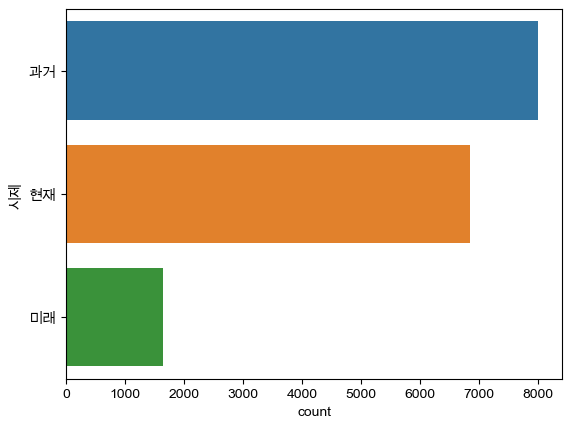

In [10]:
import matplotlib.pyplot as plt

sns.countplot(y=train['시제'], data=train,order = train['시제'].value_counts().index)
plt.show()

---
## 01. 문장 클렌징

In [11]:
import re

def apply_regular_expression(df):
    # 말뭉치
    corpus_0 = train['문장'].tolist()
    corpus = ' '.join(corpus_0)

    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]')  # 한글 추출 규칙: 띄어 쓰기(1 개)를 포함한 한글
    result = hangul.sub('', corpus)  # 위에 설정한 "hangul"규칙을 "text"에 적용(.sub)시킴
    return result

apply_regular_expression(train['문장'])[:100]

'포인트 금리 인상은 년 이후 년 만에 처음이다 이어 앞으로 전문가들과 함께 주 단위로 상황을 재평가할 예정이라며 그 이전이라도 방역 지표가 기준을 충족하면 확진자 격리의무 조정 여'

In [12]:
stop_words = ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한']

from konlpy.tag import Okt
t = Okt()

# 형태소
def morps_stopwords(sentence):
    t = Okt()
    nouns = t.morphs(sentence,stem=True)
    nouns = [i for i in nouns if not i in stop_words]

    return nouns


In [13]:
morps_stopwords(apply_regular_expression(train['문장'])[:15])

['포인트', '금리', '인상', '년', '이후']

In [14]:
train.head()

,ID,문장,시제
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,현재
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,과거
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,미래
3,TRAIN_00003,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",과거
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,현재


---
## 02. Customize mecab Tokenizer 
 - 필요한 형태소는 ?
 - mecab은 'ㄴ다' 형태 안나와서 x
 - kkma 'ㄴ다' 출력 o /이같은 -> '이', '같', '은'
 - hannanum 'ㄴ다' 출력 o /이같은 -> '이같은'M

 - hannanum tagset
 ```
 {'E': '어미',
 'EC': '연결 어미',
 'EF': '종결 어미',
 'EP': '선어말어미',
 'ET': '전성 어미',
 'F': '외국어',
 'I': '독립언',
 'II': '감탄사',
 'J': '관계언',
 'JC': '격조사',
 'JP': '서술격 조사',
 'JX': '보조사',
 'M': '수식언',
 'MA': '부사',
 'MM': '관형사',
 'N': '체언',
 'NB': '의존명사',
 'NC': '보통명사',
 'NN': '수사',
 'NP': '대명사',
 'NQ': '고유명사',
 'P': '용언',
 'PA': '형용사',
 'PV': '동사',
 'PX': '보조 용언',
 'S': '기호',
 'X': '접사',
 'XP': '접두사',
 'XS': '접미사'}
 ```

In [15]:
from konlpy.tag import Kkma
kkma = Kkma()

sent = apply_regular_expression(train['문장'])[250:300]
kkma.pos(sent)

[('거꾸로', 'MAG'),
 ('놓', 'VV'),
 ('고', 'ECE'),
 ('소금', 'NNG'),
 ('으로', 'JKM'),
 ('코', 'NNG'),
 ('를', 'JKO'),
 ('막', 'VV'),
 ('아', 'ECD'),
 ('가득', 'MAG'),
 ('채우', 'VV'),
 ('ㄴ다', 'ECS'),
 ('이', 'NP'),
 ('같', 'VA'),
 ('은', 'ETD'),
 ('변화', 'NNG'),
 ('를', 'JKO'),
 ('포함', 'NNG'),
 ('하', 'XSV'),
 ('어', 'ECS'),
 ('올해', 'NNG'),
 ('종', 'NNG'),
 ('부세', 'NNG'),
 ('과세', 'NNG'),
 ('대상', 'NNG'),
 ('은', 'JX')]

In [16]:
from konlpy.tag import Hannanum
hannanum = Hannanum()

sent = apply_regular_expression(train['문장'])[250:300]
kkma.pos(sent)


[('거꾸로', 'MAG'),
 ('놓', 'VV'),
 ('고', 'ECE'),
 ('소금', 'NNG'),
 ('으로', 'JKM'),
 ('코', 'NNG'),
 ('를', 'JKO'),
 ('막', 'VV'),
 ('아', 'ECD'),
 ('가득', 'MAG'),
 ('채우', 'VV'),
 ('ㄴ다', 'ECS'),
 ('이', 'NP'),
 ('같', 'VA'),
 ('은', 'ETD'),
 ('변화', 'NNG'),
 ('를', 'JKO'),
 ('포함', 'NNG'),
 ('하', 'XSV'),
 ('어', 'ECS'),
 ('올해', 'NNG'),
 ('종', 'NNG'),
 ('부세', 'NNG'),
 ('과세', 'NNG'),
 ('대상', 'NNG'),
 ('은', 'JX')]

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16506 entries, 0 to 16539
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      16506 non-null  object
 1   문장      16506 non-null  object
 2   시제      16506 non-null  object
dtypes: object(3)
memory usage: 515.8+ KB


In [18]:
from konlpy.tag import Hannanum
hannanum = Hannanum()

sent = '0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.'
hannanum.pos(sent)


[('0.', 'N'),
 ('75%포인트', 'N'),
 ('금리', 'N'),
 ('인상', 'N'),
 ('은', 'J'),
 ('1994년', 'N'),
 ('이후', 'N'),
 ('28년', 'N'),
 ('만', 'N'),
 ('에', 'J'),
 ('처음', 'N'),
 ('이', 'J'),
 ('다', 'E'),
 ('.', 'S')]

In [19]:
train.columns

Index(['ID', '문장', '시제'], dtype='object')

In [20]:
train.head()

,ID,문장,시제
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,현재
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,과거
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,미래
3,TRAIN_00003,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",과거
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,현재


In [21]:
stopwords = ['은','는','가','하','아','것','들','의','있','되','수','보','주','등','한']
train['sig_morphs'] = None

def tokenizer(df, pos=["J","E"], stopword=stopwords): 
    from konlpy.tag import Hannanum
    hannanum = Hannanum()
    
    for idx, row in train['문장'].iteritems():
        #print(idx)
        #print(row)
        sig_morp = [word for word, tag in hannanum.pos(row) if len(word) > 0 and tag in pos and word not in stopword]
        #sig_morp = ' '.join(map(str, sig_morp))
        train['sig_morphs'][idx] = str(sig_morp[0:])
        #return sig_morp

tokenizer(train)
    

In [22]:
train.head()

,ID,문장,시제,sig_morphs
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,현재,"['에', '이', '다']"
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,과거,"['이', '어', '으로', '과', '로', '을', 'ㄹ', '이', '며',..."
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,미래,"['을', '어', '부터', '까지', '어', '을', '에서', '까지', '..."
3,TRAIN_00003,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",과거,"['이', 'ㄴ', '을', '겠다', '고', '었지만', '에', '와', '로..."
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,현재,"['ㄴ', '에', '어', '고', '으로', '를', 'ㄴ다']"


In [23]:
# 리스트 제거
train['sig_morphs']  = train['sig_morphs'] .apply(lambda x: x[1:-1])

In [24]:
train.head()

,ID,문장,시제,sig_morphs
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,현재,"'에', '이', '다'"
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,과거,"'이', '어', '으로', '과', '로', '을', 'ㄹ', '이', '며', ..."
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,미래,"'을', '어', '부터', '까지', '어', '을', '에서', '까지', 'ㄴ다'"
3,TRAIN_00003,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",과거,"'이', 'ㄴ', '을', '겠다', '고', '었지만', '에', '와', '로는..."
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,현재,"'ㄴ', '에', '어', '고', '으로', '를', 'ㄴ다'"


---
## 03. Tfidf
- 위에서 생성한 vectorizer을 인스턴스화 하고 shape를 살펴보면 2개의 컬럼으로 이루어져 있는 것을 알 수 있습니다. ex) (9321,301506)
이는 coo_matrix에서 개선된 매트릭스 이며 앞에 9321는 학습한 문자의 수 , 뒤 301506은 학습에 사용된 단어 갯수라는 것을 알 수 있습니다.



In [25]:
# 1. 문장(Text) 벡터화 -> TfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(min_df = 4, analyzer = 'word', ngram_range=(1, 2))
tf.fit(np.array(train['sig_morphs']))

sig_morphs_vec = tf.transform(train['sig_morphs'])
sig_morphs_voca = tf.vocabulary_

sig_morphs_prob = {x : y for x, y in zip(sig_morphs_vec.indices, sig_morphs_vec.data)}
sig_morphs_voca

{'으로': 826,
 '었다': 522,
 '으로 었다': 871,
 '부터': 346,
 '까지': 104,
 '에서': 704,
 'ㄴ다': 2,
 '부터 까지': 349,
 '까지 에서': 126,
 '에서 까지': 716,
 '까지 ㄴ다': 105,
 '겠다': 78,
 '었지만': 604,
 '로는': 250,
 '겠다 었다': 79,
 '으로 ㄴ다': 827,
 'ㄴ다는': 13,
 '에서 으로': 768,
 '으로 ㄴ다는': 828,
 '에서 ㄴ다는': 706,
 'ㄴ다는 으로': 19,
 '었던': 550,
 '아ㄴ': 400,
 '었던 으로': 563,
 '으로 아ㄴ': 857,
 '에는': 655,
 '에는 었다': 671,
 '에서는': 777,
 '에선': 805,
 '다가': 162,
 '어서': 458,
 '면서': 301,
 '으로 다가': 841,
 '어서 면서': 463,
 '면서 ㄴ다': 302,
 '어야': 476,
 'ㄴ지': 40,
 'ㄴ지 었다': 43,
 '까지 까지': 107,
 '이를': 955,
 '자는': 956,
 '지만': 965,
 '지만 어야': 971,
 '어야 ㄴ다': 477,
 '하고': 991,
 '하고 ㄴ다': 992,
 '아ㄴ데': 404,
 '었을': 588,
 '거나': 61,
 'ㄴ데': 30,
 '만큼': 295,
 '거나 거나': 63,
 '만큼 었다': 297,
 '었어': 565,
 '었던 에는': 560,
 '로부터': 259,
 '어야 었다': 484,
 '아다': 424,
 '었던 아다': 556,
 '아다 ㄴ다': 425,
 '었지': 601,
 '었지 었다': 603,
 '에서 에서': 763,
 '에서 었다': 750,
 'ㄹ까': 44,
 '부터 에서': 359,
 '까지 었다': 119,
 '가는': 55,
 '가는 었다': 56,
 '었다면': 543,
 '까지 었을': 122,
 '이나': 938,
 '이라도': 951,
 '이나 에서': 948,
 '었지만 었다

In [26]:
train['sig_morphs'].head()

0                                        '에', '이', '다'
1    '이', '어', '으로', '과', '로', '을', 'ㄹ', '이', '며', ...
2     '을', '어', '부터', '까지', '어', '을', '에서', '까지', 'ㄴ다'
3    '이', 'ㄴ', '을', '겠다', '고', '었지만', '에', '와', '로는...
4                  'ㄴ', '에', '어', '고', '으로', '를', 'ㄴ다'
Name: sig_morphs, dtype: object

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16506 entries, 0 to 16539
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          16506 non-null  object
 1   문장          16506 non-null  object
 2   시제          16506 non-null  object
 3   sig_morphs  16506 non-null  object
dtypes: object(4)
memory usage: 1.1+ MB


In [28]:
sig_morphs_vec

<16506x1026 sparse matrix of type '<class 'numpy.float64'>'
	with 46612 stored elements in Compressed Sparse Row format>

---
## 04. 

- X_train 나누는 부분 다시 생각하기 . 
vectorize 한 값 넣는건 아닌 듯

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train['시제'])

X = sig_morphs_vec
y = le.transform(train['시제'])
# y = train['극성'] # 딥러닝이 아니라 정수형태로 넘겨주지 않아도 분류 자체는 가능

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

In [31]:
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

tree = DecisionTreeClassifier(random_state=13, max_depth=4)
rf = RandomForestClassifier()

tree.fit(X_train, y_train)
rf.fit(X_train, y_train)

pred_tree = tree.predict(X_val)
pred_rf = rf.predict(X_val)

print('Decision accuracy_score : ', accuracy_score(y_val, pred_tree))
print('Decision f1_score : ', f1_score(y_val, pred_tree, average='weighted'))
print('----------')
print('RandomForest accuracy_score : ', accuracy_score(y_val, pred_rf))
print('RandomForest f1_score : ', f1_score(y_val, pred_rf, average='weighted'))




Decision accuracy_score :  0.8364627498485766
Decision f1_score :  0.8013272142588589
----------
RandomForest accuracy_score :  0.8210175651120533
RandomForest f1_score :  0.7966586674082448


In [32]:
# max_depth를 다양하게 하기 위해 GridSearchCV 이용
# cv를 5로 잡았으니 4:1로 나뉘어서 4개는 train, 1개를 validation으로 잡음.-> 이걸 사용/ test데이터는 별개.

from sklearn.model_selection import GridSearchCV

params ={
    'max_depth' : [2, 4, 6, 8, 10]
}

grid_cv = GridSearchCV(tree, param_grid=params, scoring='accuracy',
                        cv=5, return_train_score=True)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=4, random_state=13),
             param_grid={'max_depth': [2, 4, 6, 8, 10]},
             return_train_score=True, scoring='accuracy')

In [33]:
pred = tree.predict(X_val)
print('GridSearchCV accuracy_score : ', accuracy_score(y_val, pred))

GridSearchCV accuracy_score :  0.8364627498485766


In [34]:
grid_cv.best_score_ , grid_cv.best_params_

(0.8323994871088776, {'max_depth': 8})

In [35]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
cv_results_df = cv_results_df[['param_max_depth', 'mean_test_score', 'mean_train_score']]
cv_results_df.head()

,param_max_depth,mean_test_score,mean_train_score
0,2,0.827628,0.828253
1,4,0.831491,0.834633
2,6,0.832172,0.836868
3,8,0.832399,0.839708
4,10,0.831264,0.842907


In [36]:
best_dt_clf = grid_cv.best_estimator_
pred1 = best_dt_clf.predict(X_val)

accuracy_score(y_val, pred1)

0.8346456692913385

In [37]:
params = {
    'max_depth' : [6, 8, 10],
    'n_estimators' : [50, 100, 200],
    'min_samples_leaf' : [8, 12],
    'min_samples_split' :[8, 12]
}

rf_clf = RandomForestClassifier(random_state=13, n_jobs =-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=-1, random_state=13),
             n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10], 'min_samples_leaf': [8, 12],
                         'min_samples_split': [8, 12],
                         'n_estimators': [50, 100, 200]})

In [38]:
# 결과 정리를 위한 작업

cv_results_df = pd.DataFrame(grid_cv.cv_results_)
target_col = ['rank_test_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth']
cv_results_df[target_col].sort_values('rank_test_score').head()


,rank_test_score,mean_test_score,param_n_estimators,param_max_depth
29,1,0.831490,200,10
27,1,0.831490,50,10
26,1,0.831490,200,10
24,1,0.831490,50,10
17,5,0.831263,200,8


In [39]:
grid_cv.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=8, min_samples_split=8,
                       n_estimators=50, n_jobs=-1, random_state=13)

In [40]:
grid_cv.best_score_

0.8314904574371402

In [41]:
rf_clf_best = grid_cv.best_estimator_
rf_clf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=8, min_samples_split=8,
                       n_estimators=50, n_jobs=-1, random_state=13)

In [42]:
pred = rf_clf_best.predict(X_val)
accuracy_score(y_val, pred)

0.8340399757722592

In [43]:
# from sklearn.metrics import accuracy_score

# y_pred_tr = pipe.predict(X_train)
# y_pred_test= pipe.predict(X_val)

# print('Train acc : ', accuracy_score(y_train,y_pred_tr))
# print('Test acc : ', accuracy_score(y_val,y_pred_test))

In [ ]:
# from sklearn.model_selection import KFold

# kfold = KFold(n_splits=5)
# wine_tree_cv = DecisionTreeClassifier(max_depth=2, random_state=13)

# print(kf.get_n_splits(X))
# print(kf)